# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
print(ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/data/ly/pycharm/Mask_RCNN-master


Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448
    IMAGE_SHAPE = [448, 448, 3]

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5


config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'unet_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
from PIL import Image
import re, csv, yaml
import cv2
from libtiff import TIFF
class SpaceNetDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """  
    def __init__(self):
        super(SpaceNetDataset, self).__init__()
        
        with open('/home/data/ly/dl_data/spacenet/AOI_5_Khartoum_Train/test.yaml', 'r') as f:
            self.data = yaml.load(f)
        
    def get_obj_index(self, image):
        n = np.max(image)
        return n
    def load_shapes(self, img_list, img_floder, mask_floder):
        """Generate the requested number of synthetic images.
        #count: number of images to generate.
        image_id_list : list of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "shapes")
        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        #imglist = os.listdir(img_floder)
        for i in img_list:
            # 获取图片宽和高          
            #filestr = imglist[i]
            image_id = i.split("_")[-1][3:-4]
#             mask_path = mask_floder + "/" + "mask_"+i
            mask_path = mask_floder + "/" + "mask_RGB-" + i.split("-")[-1]
            img_path = img_floder +"/"+i
            cv_img = cv2.imread(img_path)
            self.add_image("shapes", image_id=image_id, path= img_path,
                           width=cv_img.shape[1], height=cv_img.shape[0],
                           mask_path= mask_path)
            
    def draw_mask(self,image_id):
        #print("draw_mask-->",image_id)
        #print("self.image_info",self.image_info)
        info = self.image_info[image_id]
        img_name = "AOI_5_Khartoum_img%s"%info["id"]
        num_obj = len(self.data[img_name])
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        label = []
        for index in range(num_obj):
            pol_array = np.array([self.data[img_name][index]])
            im = np.zeros([info['height'], info['width']], dtype=np.uint8)
            cv2.fillPoly(im, pol_array,1)
            mask[:, :, index] = np.array(im)
            label.append("1")
        label = np.array(label)
        return mask, label

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        #print("image_id",image_id)
        info = self.image_info[image_id]
        #mask = np.zeros([info['height'], info['width'], 1], dtype=np.uint8)
        mask, class_ids = self.draw_mask(image_id)
        return mask, class_ids.astype(np.int32)
    
    def load_unetmask(self, image_id):
        info = self.image_info[image_id]
        unet_mask = Image.open(info['mask_path'])
        unet_mask = unet_mask.resize((448, 448))
        return unet_mask
        

    def load_image(self, image_id):
        image_path = self.image_info[image_id]['path']
        tif_img = TIFF.open(image_path)
        img = tif_img.read_image()
        index = random.randint(0, 5)
        return img[:, :, index:index+3]

In [5]:
# Training dataset

# img_dir = "/home/ly/data/dl_data/spacenet/AOI_5_Khartoum_Train/RGB_8bit"
img_dir = "/home/ly/data/dl_data/spacenet/AOI_5_Khartoum_Train/MUL-PanSharpen"
mask_dir = "/home/ly/data/dl_data/spacenet/AOI_5_Khartoum_Train/mask"
img_id_list = [ ]
imglist = os.listdir(img_dir)

dataset_train = SpaceNetDataset()
train_list = list(dataset_train.data.keys())

for i in imglist:
    img_id = i.split('_')[-1][3:-4]
    key = "AOI_5_Khartoum_img" + img_id
    name = "MUL-PanSharpen_AOI_5_Khartoum_img%s.tif"%img_id
    if key in train_list:
        img_id_list.append(name)
        
dataset_train.load_shapes(img_id_list[:20],img_dir, mask_dir)
dataset_train.prepare( )
print(len(img_id_list))
#Validation dataset
dataset_val = SpaceNetDataset()
dataset_val.load_shapes(img_id_list[-40:], img_dir, mask_dir)
dataset_val.prepare()

924


## Detection

In [8]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/data/ly/pycharm/Mask_RCNN-master/logs/shapes20180725T1702/mask_rcnn_shapes_0258.h5


/home/ly/data/dl_data/spacenet/AOI_5_Khartoum_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_5_Khartoum_img1577.tif
original_image           shape: (448, 448, 3)         min:  238.00000  max: 1391.00000  uint16
image_meta               shape: (14,)                 min:    0.00000  max:  650.00000  float64
gt_class_id              shape: (38,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (38, 4)               min:    0.00000  max:  448.00000  int32
gt_mask                  shape: (448, 448, 38)        min:    0.00000  max:    1.00000  uint8


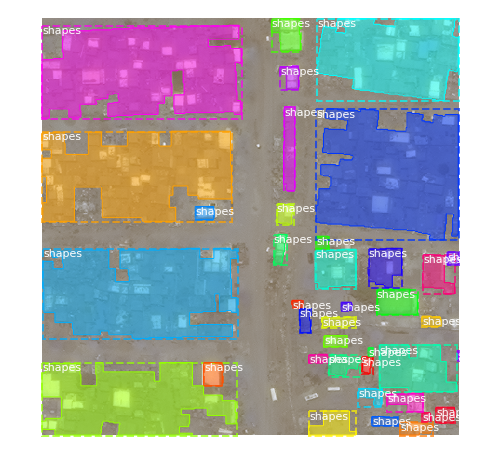

In [15]:
# Test on a random image
import cv2
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, unet_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)


print(dataset_val.image_info[image_id]['path'])
rgb_path = "/home/ly/data/dl_data/spacenet/AOI_5_Khartoum_Train/RGB_8bit/"+"RGB-PanSharpen_AOI_5_Khartoum_img%s.tif"%dataset_val.image_info[image_id]["id"]
original_image2 = cv2.imread(rgb_path)
original_image2 = cv2.resize(original_image2,(448, 448))
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
visualize.display_instances(original_image2, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (448, 448, 3)         min:  238.00000  max: 1391.00000  uint16
molded_images            shape: (1, 448, 448, 3)      min:  134.10000  max: 1274.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  448.00000  int64
anchors                  shape: (1, 50127, 4)         min:   -0.20248  max:    1.05931  float32
mask shape (448, 448)
(1, 448, 448, 1)


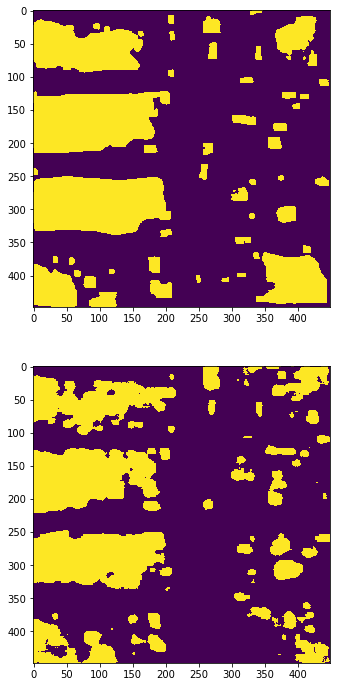

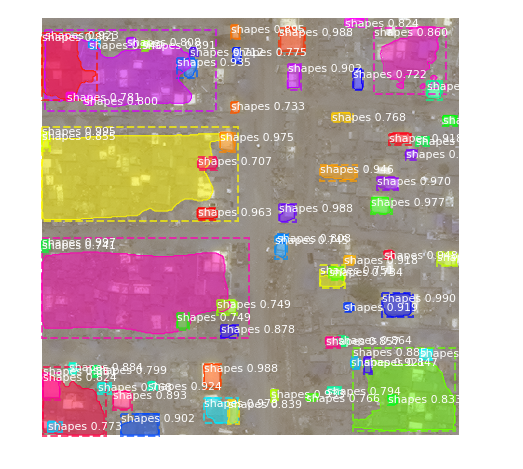

In [16]:
from keras.models import Model
from keras import backend as K

results = model.detect([original_image], verbose=1)
r = results[0]

#print(model.keras_model.summary( ))
# layer_name = "fpn_p6"

# 以 Sequential 模型为例
# print(model.keras_model.summary())
# get_3rd_layer_output = K.function([model.keras_model.layers[0].input],
#                                   [model.keras_model.layers[3].output])
# x = np.reshape(original_image,(1,448,448,3))
# layer_output = get_3rd_layer_output([x])[0]
unet_out = r['unet_out'][0,:,:,0]
unet_out = np.where(unet_out > 0.5 , 1, 0)
mask = np.sum(r['masks'], axis = -1 )
mask = np.where(mask > 1, 1, mask)
print("mask shape",mask.shape)
print(r['unet_out'].shape)
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.imshow(mask)
plt.subplot(212)
plt.imshow(unet_out)

plt.show()

visualize.display_instances(original_image2, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [16]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 30)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask, unetmask=\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.45657826932947554


In [15]:
import cv2
import numpy as np
from PIL import Image
image_id = 994
mask_dir = "/home/ly/data/dl_data/spacenet/AOI_5_Khartoum_Train/mask/"
mask_path =mask_dir + "mask_RGB-PanSharpen_AOI_5_Khartoum_img{}.tif".format(image_id)
mask = Image.open(mask_path)
w,h = mask.size
print(w, h)
mask = mask.resize((448, 448))
mask = np.array(mask, dtype = np.float32)
mask = mask.reshape(448, 448, 1)
print(mask.size)
# for i in range(w):
#     for j in range(h):
#         p = mask.getpixel((i,j))
#         if p > 0:
#             print("pixel is :",p , "[",i,j,"]")

650 650
200704


In [ ]:
from PIL import Image
mask_dir = "/home/ly/data/dl_data/spacenet/AOI_5_Khartoum_Train/mask"